# Advances in Computing with Uncertainties &mdash; Lecture 4

* Instructor: Laura Lyman
* Date: 30 September 2021
* Fall Quarter, Stanford University

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# Improve the quality of the figures
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

## Objectives

+ to practice Monte Carlo (MC) integration estimates
+ to learn how such estimates are justified by the LLN
+ to qualitatively observe the epistemic uncertainty introduced by integrating via MC


## Integrating with Monte Carlo

Let $X$ be a real-valued random variable with **probability density** $p(x)$ and $f(X)$ be a function of $X$.
We would like to calculate the integral:
$$
\mathbb{E}\left[f(X)\right] := \int f(x)p(x)dx.
$$
assuming it exists (i.e. is finite).

Later, we will look at quadrature and numerical integration techniques for estimating $\mathbb{E}\left[f(X)\right]$ more efficiently. But for now, let's observe what Monte Carlo can offer.

For background, let's recall the strong version of the <a href="https://nbviewer.jupyter.org/github/lalyman/cme-270/blob/main/lecture-notes/lecture3_sept28/lecture3-mc-examples.ipynb#TJ-sul">Law of Large Numbers</a>. The theorem states that if you have a sequence of i.i.d. random variables $Y_1, Y_2,...$ with probability density $p(x)$ and $\mathbb{E}(Y) < \infty$, then

$$
\lim_{n \rightarrow \infty} \frac{1}{n}\sum_{j=1}^n Y_j = \mathbb{E}[Y],
$$
with probability one (i.e. almost surely). 

For any function $f$, the random variables $f(X_1), f(X_2),\ldots$ are i.i.d. if the $X_1, X_2, \ldots$ are i.i.d. Therefore, if $\mathbb{E}_X(f(X)) < \infty$, by taking $Y_j = f(X_j)$  for i.i.d. $X_1, X_2,\ldots$ with $\mathbb{E}(X) < \infty$,  we have that

$$ \lim_{n \rightarrow \infty} \frac{1}{n}\sum_{j=1}^n f(X_j) = \mathbb{E}[f(X)] $$
with probability one. 

Let's try it out with a function in 1D. Suppose $X\sim\mathcal{U}(0,1)$. Consider
$$
f(x) = \left(\cos(50x) + \sin(20x)\right)^2.
$$
The correct value for the expectation can be found analytically; it is
$$
\mathbb{E}[f(x)] = 0.965.
$$

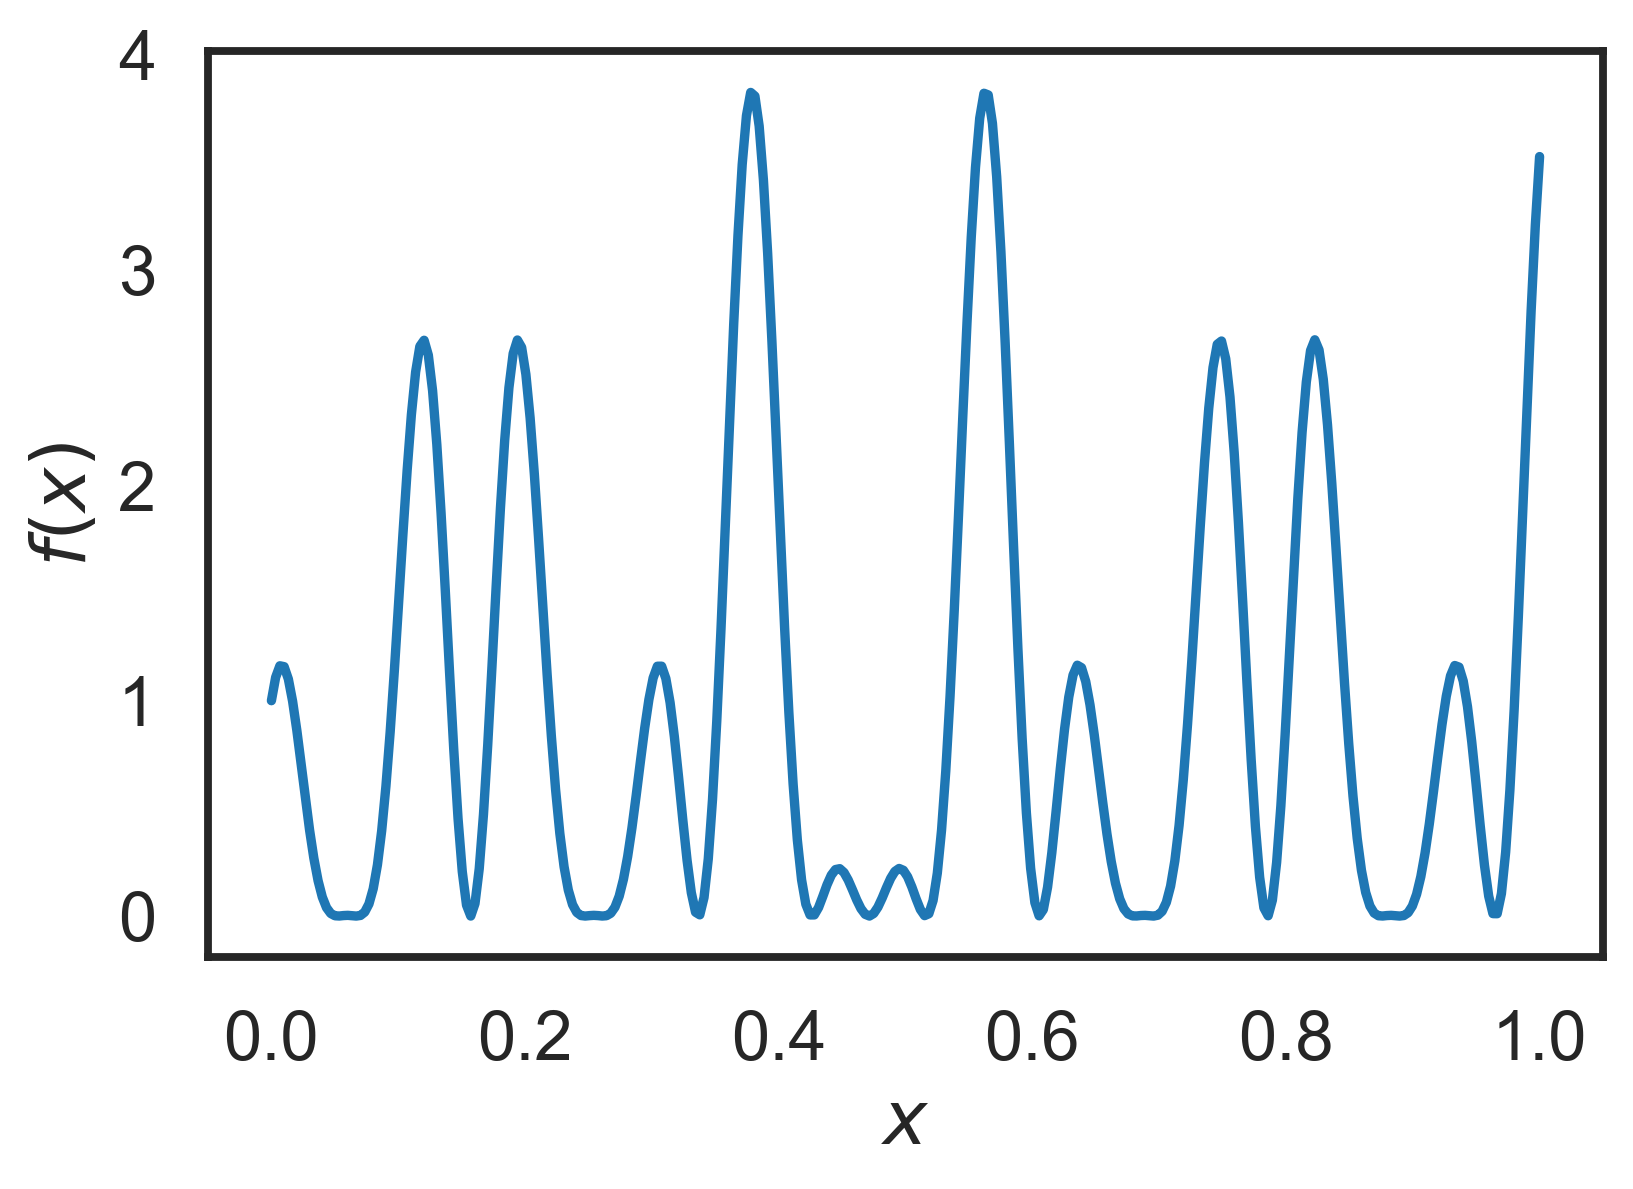

In [2]:
# Define the function
f = lambda x: (np.cos(50 * x) + np.sin(20 * x)) ** 2

# Visualize f(x)
fig, ax = plt.subplots()
x = np.linspace(0, 1, 300)
ax.plot(x, f(x))
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$');

Okay, now we can use Monte Carlo to estimate the definite integral. That is,

\begin{alignat*}{2}
\int_{-\infty}^{\infty} f(x) p(x) dx &= \int_0^1 f(x) dx \qquad &&\text{[since $p(x) = 1$ on $[0,1)$ and is 0 everwhere else]} \\
&= \int_0^1 (\cos(50x) + \sin(20x))^2 dx \quad &&\text{[definition of $f$]}  \\
&\approx \frac{1}{n} \sum_{i=1}^n (\cos(50 \thinspace X_i) + \sin(20 \thinspace X_i))^2  \quad &&\text{[for i.i.d. $X_1, \ldots, X_n \sim U(0,1)$]}
\end{alignat*}
when $n$ is large. We can write a helper function for this procedure.

In [3]:
# Estimate the 1D integral of a real-valued function f with respect to a probability density p.
# Other equivalent ways of saying this are to:
#     * approximate E_X(f)     (the expected value of f with respect to the random variable X)
#     * approximate the integral of the quantity [f(x)p(x)] over all real numbers x
#
# Of course, this function assumes that the requested integral/expected value exists
# (When people say fancy phrases like, "X is Lebesgue integerable w.r.t. the measure induced by a random 
# variable X," all they are saying is to assume the integral in question is not infinite.)
#
# The estimate of the integral is given by the sample mean with a large number of samples n, which is 
#      S_n(f) := 1/n * [f(X_i) summed from i = 1 to n].
def get_mc_estimate(max_n = 1000, func = f, sampler = np.random.rand):
    """
    Return the the MC estimate of the 1D integral using the previously defined f function.
    
    :param max_n:   Maximum number of sample
    :param func:    The function to integrate
    :param sampler: A function that samples the X_i;
                    the default is np.random.rand, which is the uniform distribution on [0,1)
    """
    S_n = np.ndarray((max_n,))  # Sample mean; an array with the running estimates of the expecation
    s = 0.                      # Variable to keep track of the sum
    for i in range(max_n):
        # Sample X_i
        X_i = sampler(1)
        # Update the sum
        s += f(X_i)
        # The current approximation of the integral is
        S_n[i] = s / (i + 1)
    return(S_n)

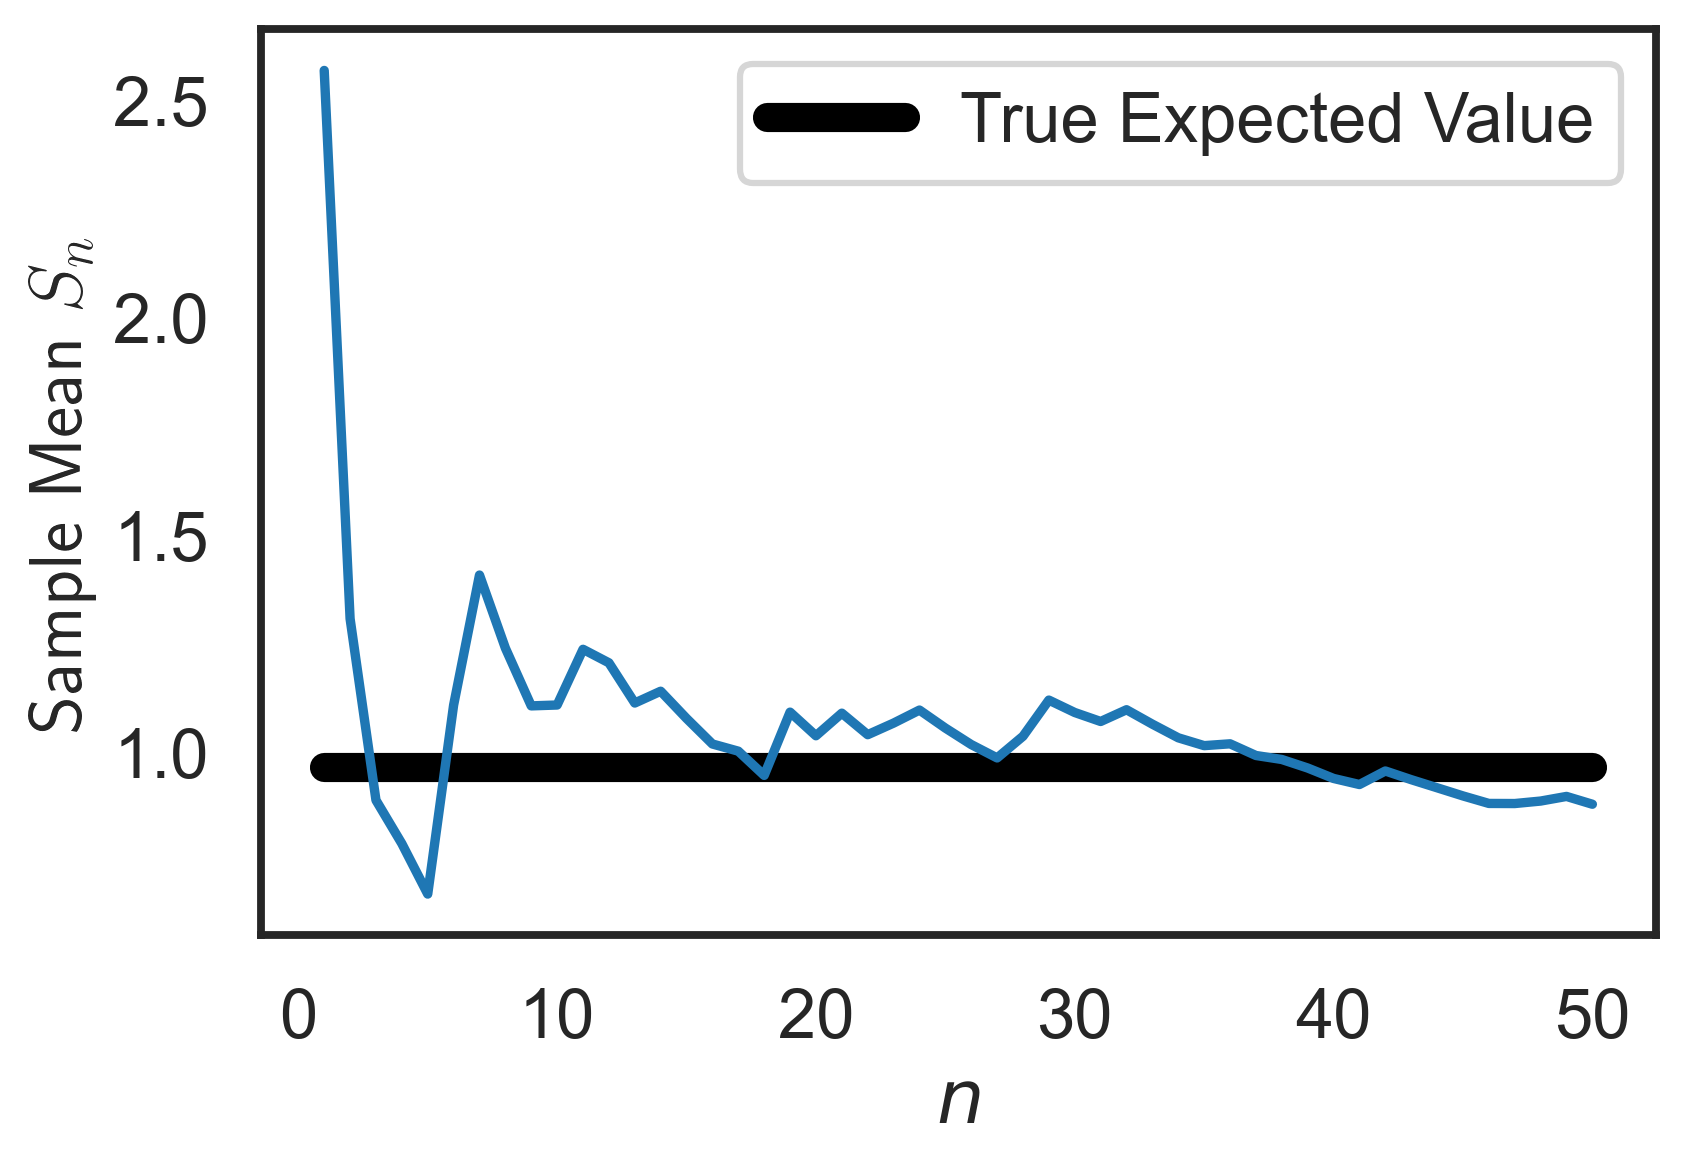

In [4]:
# Number of independent MC runs
num_mc = 1
# Maximum number of samples to take per MC run
max_n  = 50
fig, ax = plt.subplots()
# Plot the true expected value for reference
ax.plot(np.arange(1, max_n+1), [0.965] * max_n, color='black', linewidth=7.0)
for _ in range(num_mc):
    S_n_vals = get_mc_estimate(max_n = max_n, func = f)
    ax.plot(np.arange(1, max_n+1), S_n_vals)

ax.set_xlabel('$n$')
ax.set_ylabel('Sample Mean $S_n$', usetex = True);
ax.legend(['True Expected Value'])

### Exercises and Observations to Ponder

1. Run the code 2-3 times. Observe that every time you get a slightly different answer.
2. Set `num_mc` to 10. Notice how different Monte Carlo runs form an envelope around the true analytic answer (the black line).
3. Increase ``max_n`` until your get an estimate that seems close to the true answer. Try this for `num_mc` = 1 and `num_mc` = 10.

The differences in (1) and (2) come from *epistemic uncertainty*. While the values of a random variable are unknown, the output we are estimating, i.e. the expected value $\mathbb{E}_X(f(X)) = \int_0^1 f(x) dx$, is a *definite integral*. To emphasize, there is nothing "random" about the quantity of interest $\mathbb{E}_X(f(X))$; it is just some number (in this case $\approx 0.965$). Yet our approximation of it reflects the uncertainty in the $X_i$ "measurements" we are sampling. By the LLN, the effects of such uncertainty are mitigated by taking more measurements (samples), as shown in (3).
